# Imaging Lab 2: Single Pixel Scanning

### EECS 16A: Designing Information Devices and Systems I, Fall 2020

# Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Overview](#overview)
* [Task 1: Images, Vectors, and Matrices](#images)
    * [Task 1a: Working with Images](#task2a)
    * [Task 1b: Scanning Mask Matrix](#task2b)
* [Task 2: Imaging Simulated Pictures](#task3)
    * [Task 2a: Software Setup](#setup)
* [Checkoff](#checkoff)

<a id='instructions'></a>
# <span style='color:blue'>Instructions</span>
* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.


* When you finish, submit a checkoff request to get checked off for this lab. Make sure to keep your setup ready to demo and be prepared to answer a few questions to show your understanding of each section.


* Labs will be graded based on completion for teams of 2-4 students.

<a id='policies'></a>
# <span style='color:blue'>Lab Policies</span>
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are free to stay for the full allotted time and hack around with the lab setup or code, but please reserve the GSI's time for lab-related questions.**
* **Keep food and drinks away from your devices / equipment.**

# <a id='overview'><span style='color:blue'>Overview</span></a>
<center>
<img src="images/system_diagram.svg" style="height:256px" />
</center>
This week, you will write code in your Jupyter notebook to simulate scanning an image pixel-by-pixel and display the captured image. In a physical lab, your setup would resemble the one below, in which you'd set up a projector and light sensor circuit (from Imaging 1) to behave like a single pixel camera. The physical single pixel camera process would involve the following steps:
<ul>
    <li> The projector illuminates the image with a mask. </li>
    <li> The ambient light sensor detects how much light is reflected off the image. More light leads to more current through the sensor. </li>
    <li> The analog circuit converts the sensor's current into an output voltage. More ambient light $\rightarrow$ higher sensor current $\rightarrow$ higher output voltage. </li>
    <li> This analog voltage is converted into a digital brightness value. </li>
</ul>

To prevent room lighting from affecting these measurements, the projector setup is usually placed in a closed cardboard box. While the projector applies masks onto the image being scanned, the light sensor detects the brightness of the illuminated pixels.

<br><br>
<center>
<img src="images/projector_setup.png" style="height:256px" />
</center>

In this virtual version of the lab, you will do the following:
<ol>
    <li> Write code to generate the mask patterns that the simulated projector code uses to scan the image. </li>
    <li> Use your mask patterns to "photograph" an image with the simulation code and output the captured pixel values. </li>
    <li> Write code to recreate the image from these captured light sensor readings. </li>
    </font>
</ol>    

<b>Note:</b> In the real world, we come across random irregular fluctuations while taking measurements. This is called noise. It is important to consider noise while designing any system, and this lab is no different. The `noise` variable defined in each "noisy imaging"-labeled simulation cell will introduce some variability into the image measurements captured. It has been included to simulate the limitations of real-life lab equipment. You will learn more about noisy imaging in the Imaging 3 lab.
</font>    

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%run scripts/test.py

<a id='images'></a>
# <span style='color:blue'>Task 1: Images, Vectors, and Matrices </span>

<a id='task2a'></a>
## <span style="color:blue">Task 1a: Working with Images</span>

<br>
    
How can we represent an image? Consider a 5x5 grayscale image, where each of the 25 pixel intensities vary in shades of gray. One way to represent this is with a 2-D matrix (2-D NumPy array). The values stored in this array, varying from 0 to 1, correspond to different shades of gray: the lower the pixel value, the darker the pixel.  

For example, take the 5x5 **`gradient_image`** shown below. Starting from the top-left pixel (pixel[0,0]), each pixel becomes progressively brighter as you traverse the image row-by-row. Note that we will be using 0 indexing in lab as most programming languages (including Python) index in lists starting from 0.

<center>
<img src="images/gradient.JPG" align="center" style="height:200px" />
<figcaption>Gradient image example.</figcaption>
</center>

We can create this in Python using a $5 \times 5$ NumPy 2-D array called **`gradient_image`** with *linearly-spaced* floating point values from 0 to 1. The Python code to generate this is provided for you below. Take a look at the numerical 2-D array and the corresponding image that is displayed by using the `imshow` function.
</font>

[[0.         0.04166667 0.08333333 0.125      0.16666667]
 [0.20833333 0.25       0.29166667 0.33333333 0.375     ]
 [0.41666667 0.45833333 0.5        0.54166667 0.58333333]
 [0.625      0.66666667 0.70833333 0.75       0.79166667]
 [0.83333333 0.875      0.91666667 0.95833333 1.        ]]


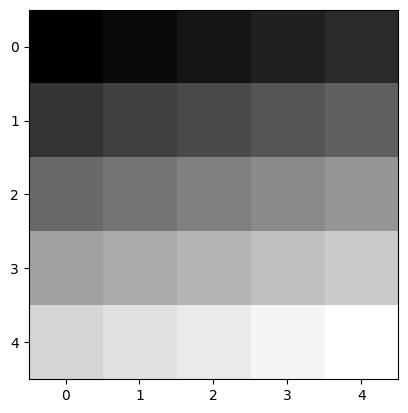

In [2]:
# A 5x5 gradient image with values from 0 to 1.
gradient_image = np.linspace(0, 1, 25).reshape([5, 5])

print(gradient_image)
plt.imshow(gradient_image, cmap="gray", interpolation="nearest")

**<span style="color:red">What color does 1.0 correspond to? What about 0?</span>**

Color with a value of 1 corresponds to a black pixel.

Instead of treating our images as 2-D matrices, we can "reshape" or "flatten" our images into 1-D vectors. That is, instead of having a $5 \times 5$ matrix for our image, we can represent it using a $25 \times 1$ vector. This makes it simpler for us to use the linear algebra techniques learned in class for image processing. 
    
Let's look at the 3x3 example image below (colored for illustrative purposes). How can we transform this 2-D vector matrix into a 1-D column vector? 
    
Essentially, the $0$th row is flipped on its side (rotate clockwise 90 degrees), such that its left-most element is on top and its right-most element is on the bottom. The $1$st row is also flipped on its side in the same way and appended below. These steps are repeated for each subsequent row of the original 2D image until you build a` $9 \times 1$ **column vector**.    

<center>
<img src="images/matrix_to_col_new.png" style="width:500px"/>
</center>

Mathematically, each pixel value in the $3 \times 3$ image is represented as a variable $p_{ij}$, where $i$ is the row and $j$ is the column associated with the pixel location. This same image represented as a 1-D column vector (called $\vec{i}$) is:

$$\vec{i} = \begin{bmatrix} p_{00} \\ p_{01} \\ p_{02} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{20} \\ p_{21} \\ p_{22} \end{bmatrix}$$    
    
The procedure described above can be used to convert any $N \times M$ 2-D image into a `num_pixels` $\times 1$ **column vector**, where `num_pixels` $= N \times M$.    

**<span style="color:red">Convert the 5x5 `gradient_image` that you created above into a 25x1 column vector `gradient_image_vector` and display it. You will find the command `np.reshape` helpful. What do you notice?</span>**

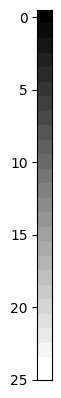

In [3]:
# TODO: Convert the 5x5 matrix into a 25x1 column vector
gradient_image_vector = np.reshape(gradient_image, (25, 1))

# Display the vector
plt.imshow(gradient_image_vector, cmap="gray", interpolation="nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

<a id='task2b'></a>
## <span style="color:blue">Task 1b: Scanning Mask Matrix</span>

Next, we will create a "mask" matrix (array) to enable our simulated projector to illuminate and scan individual pixels, one at a time. This is the magic behind our virtual single pixel camera. 

If **`gradient_image_vector`** is represented by the column vector variable $\vec{i}$, the act of transforming $\vec{i}$ by a matrix $H$ into another 1D column vector $\vec{s}$ is represented mathematically as:

$$ \vec{s} = H \vec{i} $$

This matrix multiplication represents what happens when we scan an image with our virtual single pixel camera! In the context of a real-world imaging system, $H$ represents the scanning "mask matrix," whose rows are projected one-by-one onto the image we want to scan. $\vec{s}$ represents digitized readings from the analog circuit's light sensor. In the context of the simulation, each mask in $H$ will be reshaped to match the dimensions of the image, and subsequently overlaid one at a time, with only illuminated pixel measurements contributing to the corresponding mask measurement. Each element $s_k$ of $\vec{s}$ corresponds to one scan (using one row $k$ of $H$, that we refer to as $H_k$). 

Each 1D **row of $H$** represents a **mask**. But what is a mask? In the context of our virtual single pixel camera, a mask is a way to highlight certain locations in the image while hiding others during scanning. For a 3x4 image (where 3 = height, 4 = width), a mask taken from **row 0 of $H$** is represented as the $1 \times 12$ row vector below: 

$$
H_0 
= \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$

However, the mask must first be converted into its 2D form, as shown below, before it's projected over the 2D image. The mask exposes only the top-left pixel of the 2D image and hides all other pixels. Note that you can convert a 2D mask into a 1D row of $H$ by appending each of the 2D mask's rows to the right of the previous row.
<br><br>
<center>
<img src="images/black_hite.png" style="width:400px"/>
</center>
 
To expose each pixel of the 3x4 image $\vec{i}$ individually, we would need a 12x12 $H$ that has 12 masks (rows), each with a single white "exposed" pixel in a unique location. This means that **row 1 of $H$** (exposing $iv_{01}$) would look like:

$$
H_1 
= \begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$
<br><br>
<center>
<img src="images/black_white_shifted.jpg" style="width:400px"/>
</center>

The process of masking an image, one pixel at a time, and sensing the resultant ambient light performs the matrix multiplication $\vec{s} = H \vec{i}$ in real life. This equation implies that each element of the sensor output vector $\vec{s}$ can be determined as:
    
$$s_k = H_k \vec{i}$$

Where the $k$th sensor reading is determined by the $k$th row of $H$, $H_k$. Thus, projecting the 2D representation of $H_0$ shown above onto a 3x4 image represented by the column vector $\vec{i}$ to obtain the sensor reading $s_0$ would be mathematically equivalent to:

$$
s_0 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix} \vec{i}
$$

**<span style="color:red">What dimensions does the mask matrix $H$ have for a 5x5 image? Why? </span>**

5 x 5

**<span style="color:red">
Create the mask matrix $H$ for the 5x5 image.</span>**

*Hint: Google the function `np.eye`.*

H mask matrix is correct


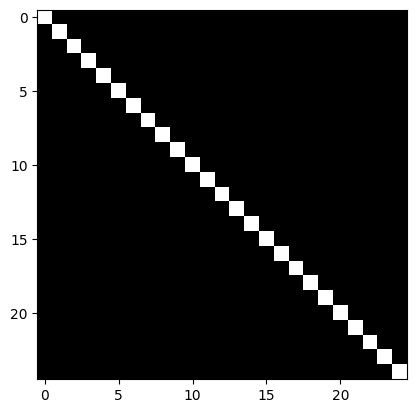

In [4]:
# TODO: Create the mask matrix `H` for scanning a 5x5 image (be careful about the dimensions!)
H = np.eye(25)

# Test H for correctness
test1b_H(H)

# Display this matrix
plt.imshow(H, cmap="gray", interpolation="nearest")

**<span style="color:red">
Multiply the $H$ matrix with `gradient_image_vector`. Remember to use `np.dot` to do matrix multiplication.</span>**

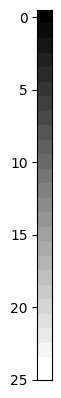

In [5]:
# TODO: Multiply `H` and `gradient_image_vector`
s = np.dot(H, gradient_image_vector)

# Display the result and compare it to `gradient_image_vector`
plt.imshow(s, cmap="gray", interpolation="nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

**<span style="color:red">Is the results `s` equal to `gradient_image_vector`? Why?</span>**

Yes, `s` is equal to the `gradient_image_vector` since all we did was multiply by the Identity matrix.

What happens when this matrix multiplication is performed? To reiterate, each row of $H$ is responsible for "illuminating," or selecting, a single pixel in the gradient image! `gradient_image_vector` was created by converting the 5x5 `gradient_image` into a 1D *column vector*. Similarly, *every row* in $H$ can be represented as a 5x5 image that, in real imaging, would be projected over `gradient_image`. 

**<span style="color:red">
Iterate through each row of the matrix $H$. *Reshape* each row into a 5x5 image, and check that each row illuminates a unique pixel of the original 5x5 image! Based on $ \vec{s} = H \vec{i} $, why are the rows of $H$ used for masking when $\vec{i}$ is a column vector?</span>**

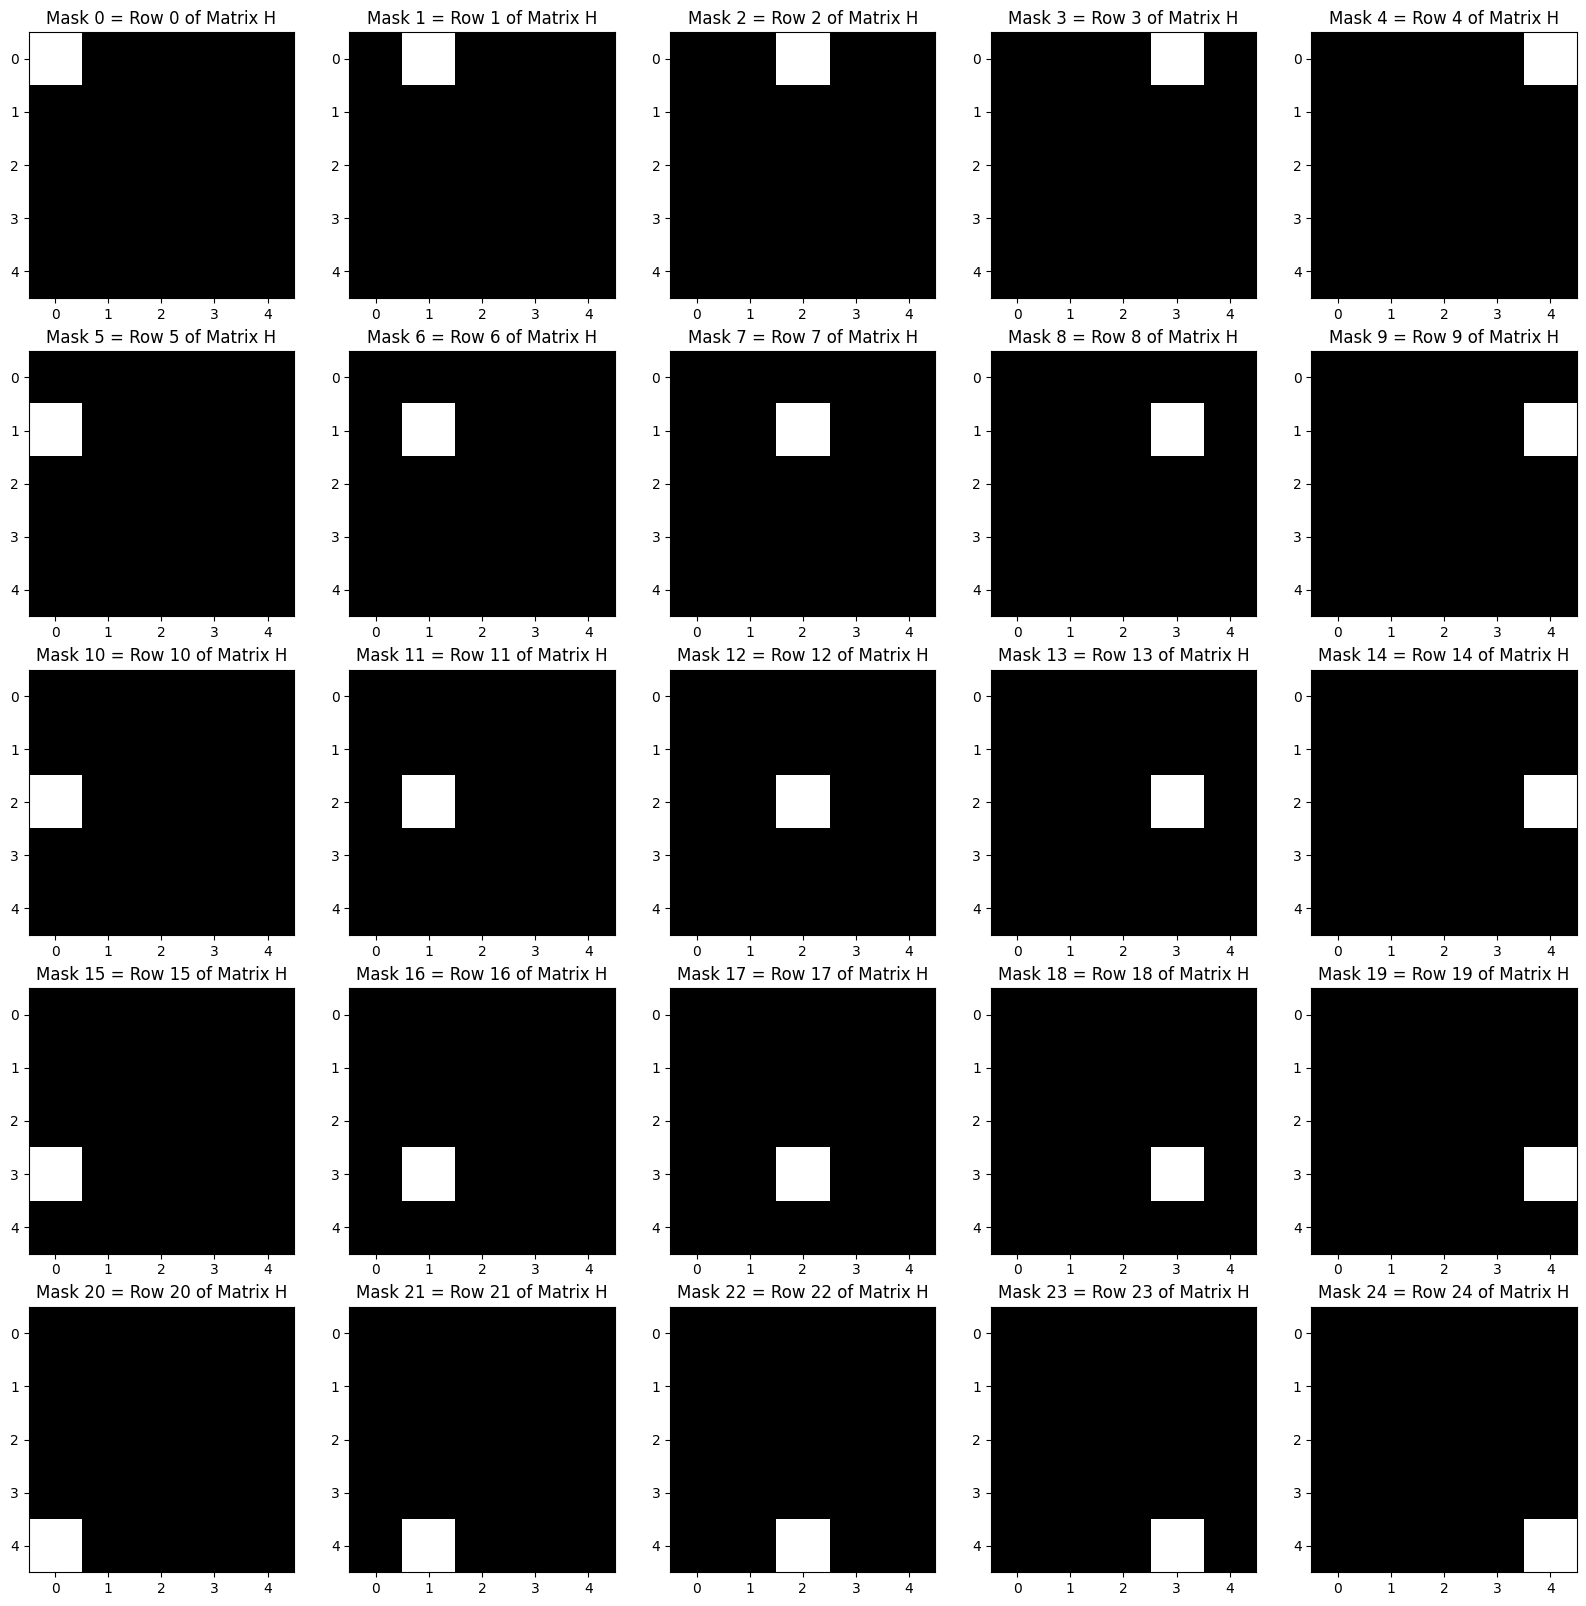

In [6]:
# Iterate through rows of matrix H and form individual masks
plt.figure(figsize=(20, 20))
for k in range(25):
    plt.subplot(5, 5, k + 1)

    mask = np.reshape(H[k], (5, 5))

    plt.imshow(mask, cmap="gray", interpolation="nearest")
    plt.title("Mask " + str(k) + " = Row " + str(k) + " of Matrix H")

Each of the images above are masks. During a single scan, we project one of these masks over our image. The white pixel illuminates a particular location on the image that we want to capture, and the black pixels obscure the other parts of the image. Thus, using the rows of $H$, we gather information one pixel at a time.

Let's try to make another mask matrix, $H_{alt}$, that's a little more complicated. We want the first (upper) half of $\vec{s}$ to contain information on every other pixel of the image (i.e. $p_{00}$, $p_{02}$, $p_{20}$...). The second (lower) half of $\vec{s}$ should consist of information on the pixels that the first half skipped (i.e. $p_{01}$, $p_{03}$, $p_{10}$).

**<span style="color:red">
Generate $H_{alt}$ whose first half (in terms of rows) illuminates every other pixel of $\vec{i}$ and whose second half illuminates the pixels that were skipped. Multiply $H_{alt}$ by `gradient_image_vector` to produce the new output vector $\vec{s}_{alt}$.
</span>**

<b>Hint</b>: Try to use rows from the existing H matrix. The syntax to slice an NumPy array is as follows `array[star_row:stop_row:skip,start_col:stop_col:skip]`. `np.vstack` may be very helpful (try Googling it). If done well, the code to generate H_alt should only be 1 short line.

H_alt mask matrix is correct


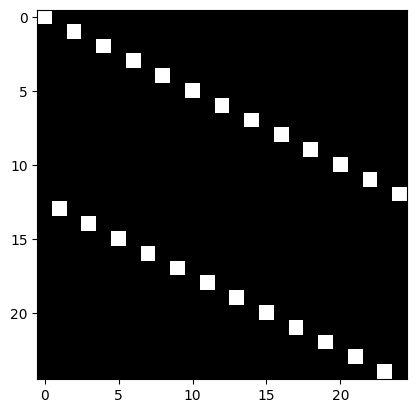

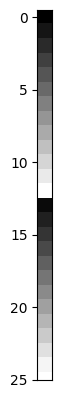

In [7]:
# TODO: Create the new mask matrix `H_alt`
H_alt = np.vstack((H[0:25:2], H[1:25:2]))

# Test H_alt for correctness
test1b_H_alt(H_alt)

# Display `H_alt`
plt.figure()
plt.imshow(H_alt, cmap="gray", interpolation="nearest")

# TODO: Multiply `H_alt` and `gradient_image_vector`
s_alt = np.dot(H_alt, gradient_image_vector)

# Display the result `s` and compare to `gradient_image_vector`
plt.figure()
plt.imshow(s_alt, cmap="gray", interpolation="nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

Because of how we designed `H_alt`, `s_alt` is clearly different from `gradient_image_vector`. Each pixel of `gradient_image_vector` is still illuminated only once by `H_alt`, but the order in which the pixels are illuminated has changed. Therefore, we say that `s_alt` is a "scrambled" version of `gradient_image_vector`. How could we "reconstruct" $\vec{s}_{alt}$ back into the original `gradient_image_vector`? 

Recall that our original matrix $H$ was actually the **identity matrix** $I_n$. In other words, the original $\vec{s}$ was computed as:

$ \vec{s} = H \vec{i} = I_n \vec{i}$

<br />    
Using the alternate mask, $H_{alt}$, we compute the alternate output $\vec{s}_{alt}$ as:

$ \vec{s}_{alt} = H_{alt} \vec{i} $

To "reconstruct" $\vec{s}_{alt}$ back into the original `gradient_image_vector` (i.e. $\vec{i}$), we must find a matrix $M$ that multiplies $\vec{s}_{alt}$ to make the following true:

$ M \vec{s}_{alt} = \vec{i} $

i.e.

$ M H_{alt} \vec{i} = I_n \vec{i} $

**<span style="color:red">What should M be to recover $\vec{i}$?</span>**

Should be the inverse of H alt

**<span style="color:red">Write code to reconstruct `gradient_image_vector` from `s_alt`.</span>**

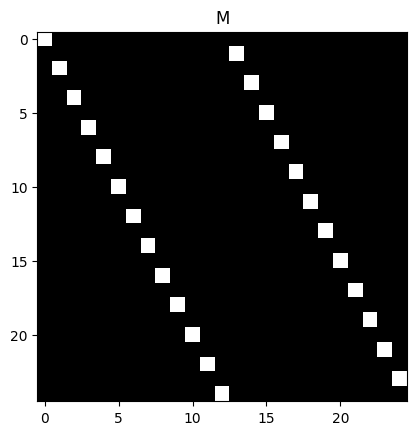

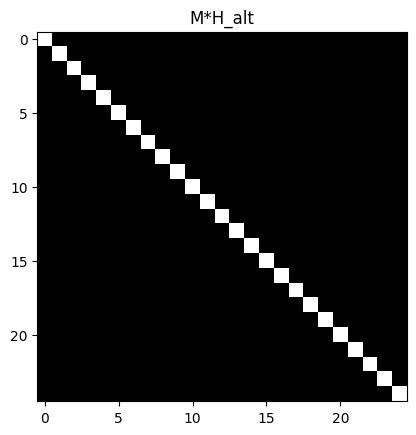

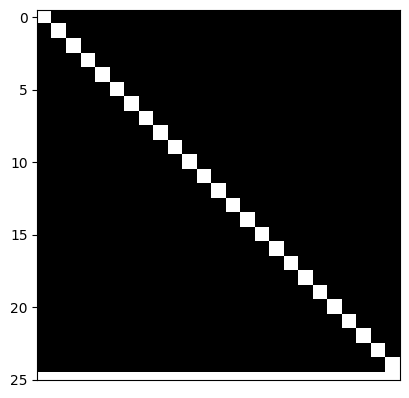

In [8]:
# TODO: Reconstruct `gradient_image_vector`
M = np.linalg.inv(H_alt)
gradient_image_vector_reconstruct = np.dot(M, H_alt)

# Display M
plt.figure()
plt.imshow(M, cmap="gray", interpolation="nearest")
plt.title("M")
plt.show()

# Display M*H_alt
plt.figure()
plt.imshow(np.dot(M, H_alt), cmap="gray", interpolation="nearest")
plt.title("M*H_alt")
plt.show()

# Display the result
plt.imshow(gradient_image_vector_reconstruct, cmap="gray", interpolation="nearest")
plt.xticks([])
plt.yticks(np.arange(0, 30, 5))
plt.show()

<a id='task3'></a>
# <span style="color:blue">Task 2: Imaging Simulated Pictures</span>

Finally, we will use our two matrices to simulate imaging a more complex picture. Because our picture is fairly large, we want each individual mask to have dimensions 32x32 (i.e. height = 32, width = 32). Think about how big the mask matrix was for the 5x5 example. In the next cell, you'll use the same logic to find the dimensions for the mask matrix of a 32x32 image.

**<span style="color:red">
Recreate both the $H$ and $H_{alt}$ masks to match these new dimensions. </span>**

In [9]:
%run scripts/helpers.py

<Figure size 640x480 with 0 Axes>

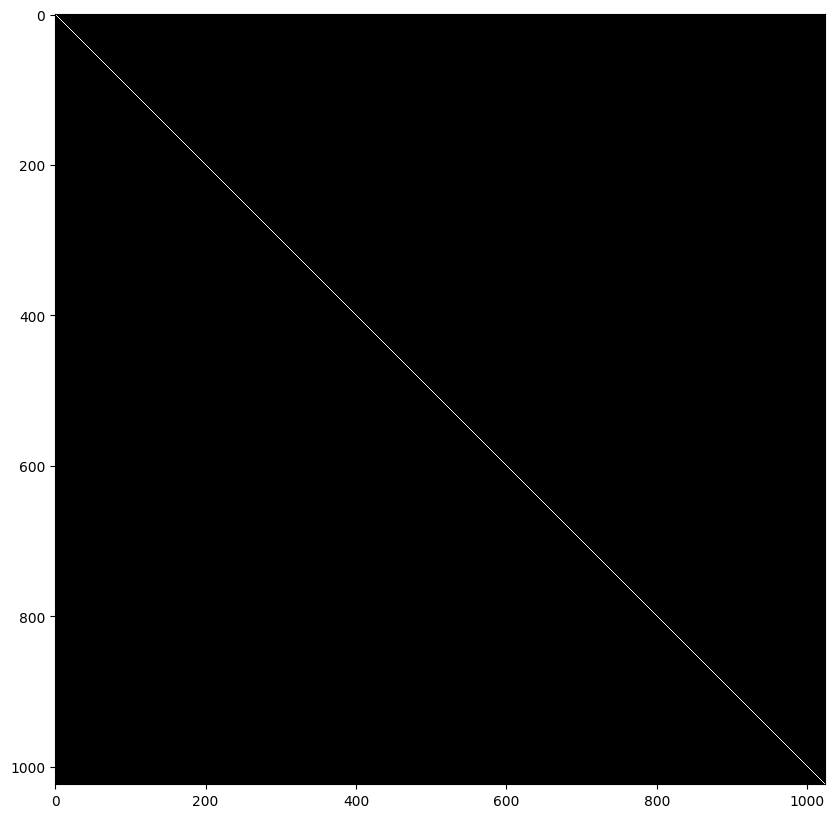

In [10]:
# TODO: Recreate `H` with new dimensions
H = np.eye(32 * 32)

plt.figure(figsize=(10, 10))
plt.imshow(H, cmap="gray", interpolation="nearest")

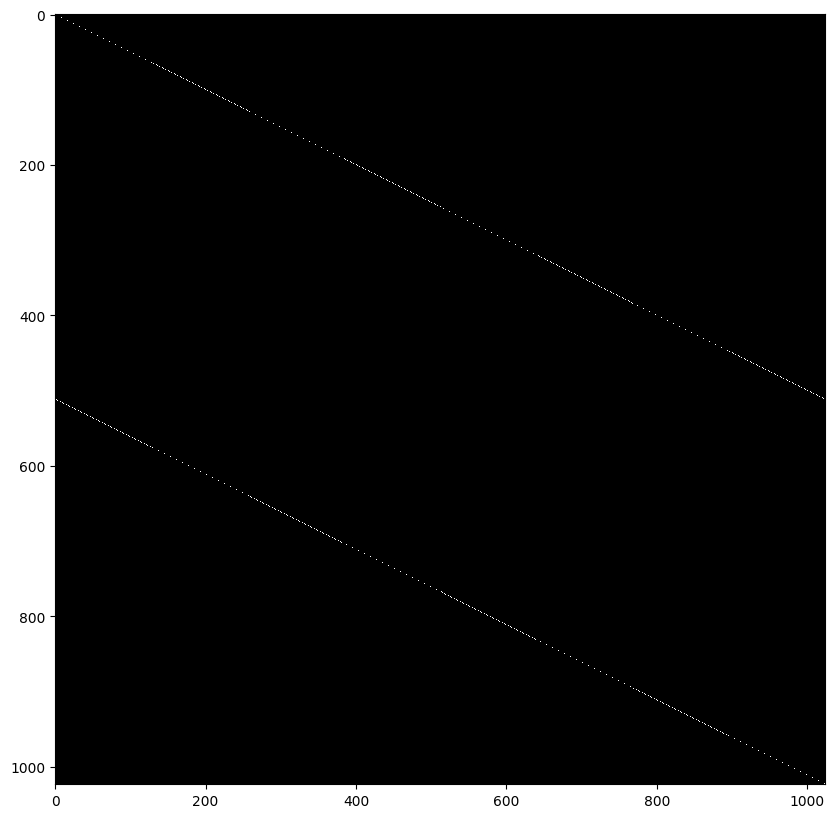

In [11]:
# TODO: Recreate `H_alt` with new dimensions
H_alt = np.vstack((H[0:1024:2], H[1:1024:2]))

plt.figure(figsize=(10, 10))
plt.imshow(H_alt, cmap="gray", interpolation="nearest")

Note: The H_alt to match new dimensions looks somewhat different from the previous 25x25 H_alt because the pixels are too tiny to be distinguished. As long as you see a pattern similar to 25x25 H_alt and pass the following test, you're correct!

Let's make sure that the two matrices we made are invertible and the correct size. Run the code block below to invert the matrices and test dimensions - if any of the lines fail, it means the code used to generate either matrix resulted in a incorrect size or non-invertible, linearly dependent matrix, which is incorrect. 

In [12]:
test2(H, H_alt)

H mask matrix is correct
H_alt mask matrix is correct


Our mask matrices must be saved as files before they can be used to perform real imaging. The files are read by our imaging script, as seen below. 

**<span style="color:red">Run the cell below to save `H` and `H_alt`!</span>**

In [13]:
np.save("saved_data/H.npy", H)
np.save("saved_data/H_Alt.npy", H_alt)

##  <a id ='setup'><span style = "color: blue">Task 2a: Software Setup</span></a>

Now, we need an object to simulate taking a picture of. You can use an image of your choice for this lab (or stick with the one we've provided :). We suggest using one that has a single object with a simple, light background; say your favorite logo/emoji/animal. 

Simply download one (using Google Images for example) or click a picture and store it in an easily accessible place on your computer. We also suggest using .jpg or .jpeg file formats (feel free to convert .png files to these formats).

This lab is designed to work with 32x32 images. We have provided a resizing script to make sure that your image works with the simulator. However, selecting a high-resolution / detailed image may lead to a possible unrecognizable resized image as 32x32 images have comparatively low resolution.

1. Open the JupyterHub directory view (tab on the left of the notebook) and hit the `Upload` button.

<br>
<center><img src="images/upload_image_new_1.png" align="center"/ width="1279" height="761">

<left>2. Navigate to your image in the pop-out window, select it and click on "Open".
    
<br>    
<center><img src="images/upload_image_new_2.png" align="center"/ width="1218" height="720">  

<left>3. Click the `Upload` button next to the image selected.
    
<br>    
<center><img src="images/upload_image_new_3.png" align="center"/ width="1218" height="720"> 

<left>4. You should see the image in the `eecs16a_imaging_lab2_fa20` folder. 
    
<br>    
<center><img src="images/upload_image_new_4.png" align="center"/ width="1218" height="720"> 

This lab is designed to work with 32x32 images. `imageResize()` takes your (higher quality) image, picks the center portion of it, and reduces its quality to fit the desired size.

**<span style="color:red">Set `uploadPath` to the name of the image you've chosen </span>** (with its extension, for example "picture.jpg") and **<span style="color:red">set `imagePath` to the name you want the resized imaged to have </span>**(with its extension, for example "picture.jpg"). 

**Note: Another reminder that passing in a path to a high-resolution / detailed image may lead to a badly resized image as 32x32px images have comparatively low resolution. The new image might be unrecognizable.**

In [14]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt

%run scripts/helpers.py
%matplotlib inline

# Image Resize
uploadPath = "eecs16a.jpg"  # TODO: replace with your uploaded image file path
imagePath = "eecs16a32x32.jpg"  # TODO: replace with the filename for your resized image
height = 32
width = 32
imageResize(uploadPath, imagePath, height, width)

<Figure size 640x480 with 0 Axes>

**<span style="color:red">You will then run the `masking_simulation.py` script below that projects mask patterns onto your image based on the $H$ matrix that you designed. </span>**  This script controls the scanning process. The following cell runs `cumulative_imaging_simulation.py` which will display the sensor vector reshaped to the original image's dimensions.

The commands in the code block below use the following tags: 
- `--mask`: points to the file (with its extension, for example "matrix.npy") associated with the mask matrix you want to use 
- `--width`, `--height`: dimensions of the image being scanned
- `--image`: specifies the path to the image being scanned (with its extension, for example "picture.jpg")
- `--overlay` (**`masking_simulation.py`** only): see each mask overlaid on the image. It is set to True by default. 

When running **`masking_simulation.py`**, a popup widget will appear, depicting the masks being applied to the image during each scan. The call to `simulateIdealImaging` directly below this will save the resulting sensor vector to the file specified by sensorFilename. 

When **`cumulative_imaging_simulation.py`** begins running, the centered popup widget will go through the captured brightness values collected so far as the number of scans increases.

`masking_simulation.py` iterates over the rows of the $H$ matrix you made. These rows are translated, one-by-one, into real masks projected onto the screen. Sensor readings are taken for each mask. At the start of the scan, you'll see a series of `Count: # Brightness value: #` printed to the output below. `Count` corresponds to the index $k$ of the current sensor reading (and likewise current row of H). `Brightness` corresponds to the digitized value obtained from imaging using the given mask. This "debug" information is printed consecutively for the first few sensor outputs. Otherwise, this info is printed when `k % 100 = 0` (every 100 scans). 

**<span style="color:red ; font-size: 20px">Please click on this <a href="https://eecs.datahub.berkeley.edu/hub/user-redirect/desktop">link</a> before proceeding any further. It will open another browser tab where the visuals will be visible. Login with your CalNet ID, if prompted. If you see a pop-up in the middle of your screen, click on `Use Default Config`. Then return back to this notebook tab.</span>**

*Note: In a real-world projector setup (**not in this virtual arrangement**), scanning would take much longer (a few minutes) because:*
* We average sensor readings to improve the signal-to-noise ratio. Therefore we need to read more times.
* As you'll learn in Module 2, capacitors take some time to charge and discharge. A capacitor acts as a "low-pass filter." We used a 0.1$\mu$F capacitor in our sensing circuit to "smooth" the output and suppress "high-frequency" noise. In order to give the capacitor time to "settle" (i.e. ~fully charge/discharge), we need to wait longer between scans. Otherwise, the sensor reading will also include some "memory" of the previous scan result, when we really want the reading to only be about the current scan. 

/Users/briancpark/dev/school/eecs16a/labs/eecs16a_imaging_lab2_fa20/scripts/masking_simulation.py:5: DeprecationWarning: Support for PyQt5 is deprecated and will be removed in Pillow 10 (2023-07-01). Use PyQt6 or PySide6 instead.
  from PIL import ImageQt



EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/H.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 255

Count: 1, Brightness value: 236

Count: 2, Brightness value: 255

Count: 3, Brightness value: 255

Count: 4, Brightness value: 243

Count: 5, Brightness value: 255

Count: 6, Brightness value: 255

Count: 7, Brightness value: 251

Count: 8, Brightness value: 253

Count: 9, Brightness value: 253

Count: 10, Brightness value: 255

Count: 100, Brightness value: 250

Count: 200, Brightness value: 220

Count: 300, Brightness value: 223

Count: 400, Brightness value: 255

Count: 500, Brightness value: 249

Count: 600, Brightness value: 250

Count: 700, Brightness value: 226

Count: 800, Brightness value: 255

Count: 900, Brightness value: 247

Count: 1000, Brightness value: 244

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

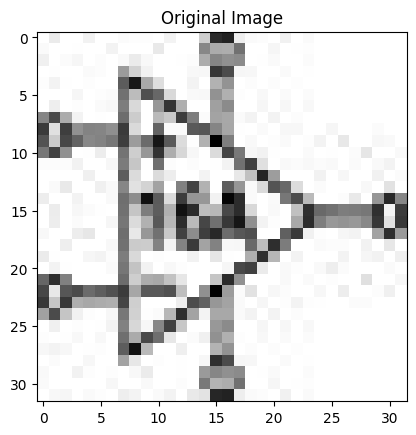

In [15]:
# Ideal Imaging
H = np.load("saved_data/H.npy")
sensorFilename = "saved_data/s_vec"

# As soon as you run this block, please open the browser tab with the visuals.
# Once both visuals have finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/H.npy" --image $imagePath --sleepTime 10
simulateIdealImaging(imagePath, H, sensorFilename, height, width)

%run scripts/cumulative_imaging_simulation.py --width 32 --height 32 --mask "saved_data/H.npy" --image $imagePath --sleepTime 10

After the sensor readings have been captured, load the sensor reading vector into the cell below. Once again, here is the equation relating $H$, the sensor reading column vector $\vec{s}$, and the image column vector $\vec{i}$:

$$\vec{s} = H \vec{i}$$

**<span style="color:red">Recreate the image from the sensor readings obtained with `H`.</span>**

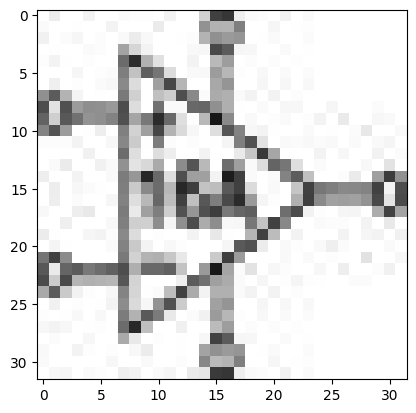

In [16]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

# TODO: Create the image vector from `H` and `sr`
# Hint: Because `H` is a special matrix, technically you do not need to perform any matrix operations
iv = np.dot(np.linalg.inv(H), sr)

img = np.reshape(iv, (height, width))
plt.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=255)

To simulate the noisy behavior of a real-world projector setup, run the following cell. We'll be coming back to the effect of noise on captured and reconstructed images in the next lab so don't worry too much about how this works right now. Feel free to play around with the `noise` parameter to observe its effect on noisiness of the reconstructed image.


EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/H.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 255

Count: 1, Brightness value: 236

Count: 2, Brightness value: 255

Count: 3, Brightness value: 255

Count: 4, Brightness value: 243

Count: 5, Brightness value: 255

Count: 6, Brightness value: 255

Count: 7, Brightness value: 251

Count: 8, Brightness value: 253

Count: 9, Brightness value: 253

Count: 10, Brightness value: 255

Count: 100, Brightness value: 250

Count: 200, Brightness value: 220

Count: 300, Brightness value: 223

Count: 400, Brightness value: 255

Count: 500, Brightness value: 249

Count: 600, Brightness value: 250

Count: 700, Brightness value: 226

Count: 800, Brightness value: 255

Count: 900, Brightness value: 247

Count: 1000, Brightness value: 244

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

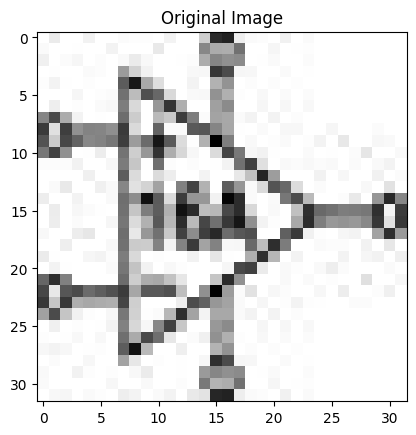

In [17]:
# Noisy Imaging
noise = 50  # you can play around with this noise parameter within the range [0, 255]
H = np.load("saved_data/H.npy")
sensorFilename = "saved_data/s_vec_nonideal"

# As soon as you run this block, please open the browser tab with the visuals.
# Once both visuals have finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/H.npy" --image $imagePath --sleepTime 10
simulateRealImaging(imagePath, H, sensorFilename, height, width, noise)

%run scripts/cumulative_imaging_simulation.py --width 32 --height 32 --mask "saved_data/H.npy" --image $imagePath --sleepTime 10 --noise $noise --noiseFile "saved_data/s_vec_nonideal_noise.npy"

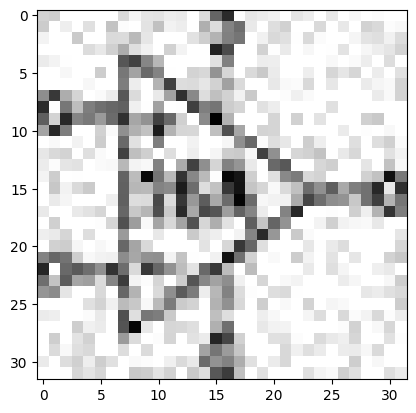

In [18]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

# TODO: Create the image vector from `H` and `sr`
# Hint: Because `H` is a special matrix, technically you do not need to perform any matrix operations
iv = np.dot(np.linalg.inv(H), sr)

img = np.reshape(iv, (height, width))
plt.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=255)

Congratulations! You have simulated imaging your first image using your virtual single pixel camera! 

**<span style="color:red">
Does your recreated image match the real image? What are some problems you notice? 
</span>**

<span style="color:red">`Yes, almost. It is a bit blurry though`</span>

For reference, here is an example picture we took using the real-world lab setup:

<center>
<img src="images/ee16a_picture.png"/>
</center>

**<span style="color:red">Next, use the second mask `H_alt` for imaging. Can you repeat the same reconstruction procedure just by replacing $H$ with $H_{alt}$? Why or why not?</span>**

No, It is nearly the same operation.. just out of order.

Run the scripts again (taking the same precautions as above) to collect sensor readings. Make sure to run it from the code block below to point the script to `H_alt`. Then reconstruct the image.


EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/H_Alt.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 255

Count: 1, Brightness value: 255

Count: 2, Brightness value: 243

Count: 3, Brightness value: 255

Count: 4, Brightness value: 253

Count: 5, Brightness value: 255

Count: 6, Brightness value: 255

Count: 7, Brightness value: 210

Count: 8, Brightness value: 54

Count: 9, Brightness value: 250

Count: 10, Brightness value: 255

Count: 100, Brightness value: 220

Count: 200, Brightness value: 255

Count: 300, Brightness value: 250

Count: 400, Brightness value: 255

Count: 500, Brightness value: 244

Count: 600, Brightness value: 253

Count: 700, Brightness value: 249

Count: 800, Brightness value: 255

Count: 900, Brightness value: 254

Count: 1000, Brightness value: 127

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0

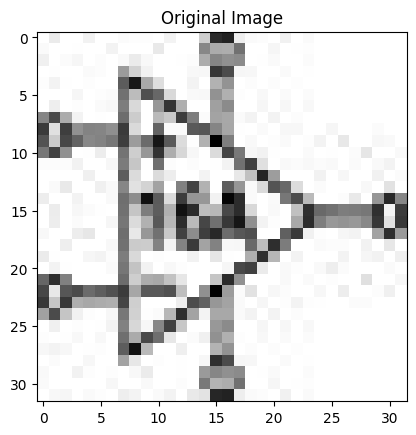

In [19]:
# Ideal Imaging
H_alt = np.load("saved_data/H_Alt.npy")
sensorFilename = "saved_data/s_alt_vec"

# As soon as you run this block, please open the browser tab with the visuals.
# Once both visuals have finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/H_Alt.npy" --image $imagePath --sleepTime 10
simulateIdealImaging(imagePath, H_alt, sensorFilename, height, width)

%run scripts/cumulative_imaging_simulation.py --width 32 --height 32 --mask "saved_data/H_Alt.npy" --image $imagePath --sleepTime 10

Text(0.5, 1.0, 'Sensor Reading, Using H_alt')

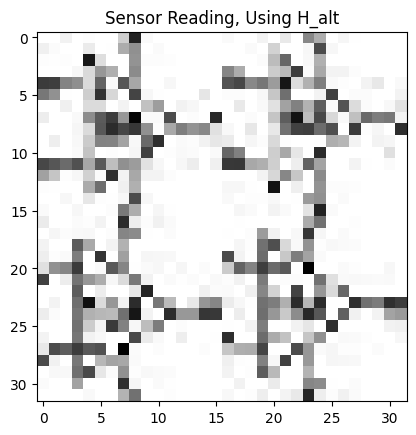

In [20]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

plt.imshow(np.reshape(sr, (width, height)), cmap="gray", interpolation="nearest")
plt.title("Sensor Reading, Using H_alt")

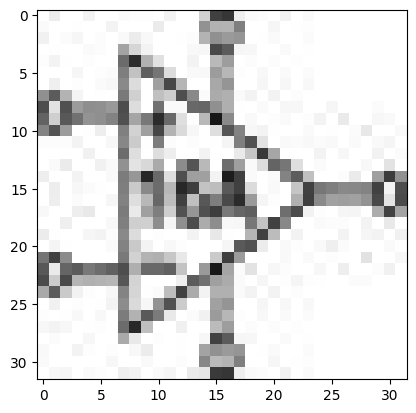

In [21]:
# TODO: Create the image vector from `H_alt` and `sr`
# Hint: You need to perform a matrix operation before multiplying
iv = np.dot(np.linalg.inv(H_alt), sr)

img = np.reshape(iv, (height, width))

plt.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=255)

Let's simulate the noise a real projector setup can introduce again, this time for the $H_{alt}$ mask matrix.


EECS16A Imaging Lab

Sleep time in ms: 10
Image width: 32
Image height: 32
Mask file: saved_data/H_Alt.npy 

Image file: eecs16a32x32.jpg 

Overlay enabled: True 

Count: 0, Brightness value: 255

Count: 1, Brightness value: 255

Count: 2, Brightness value: 243

Count: 3, Brightness value: 255

Count: 4, Brightness value: 253

Count: 5, Brightness value: 255

Count: 6, Brightness value: 255

Count: 7, Brightness value: 210

Count: 8, Brightness value: 54

Count: 9, Brightness value: 250

Count: 10, Brightness value: 255

Count: 100, Brightness value: 220

Count: 200, Brightness value: 255

Count: 300, Brightness value: 250

Count: 400, Brightness value: 255

Count: 500, Brightness value: 244

Count: 600, Brightness value: 253

Count: 700, Brightness value: 249

Count: 800, Brightness value: 255

Count: 900, Brightness value: 254

Count: 1000, Brightness value: 127

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0

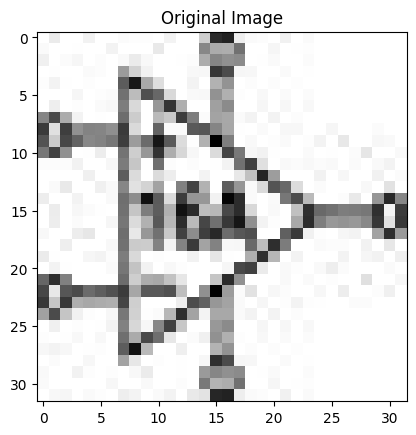

In [22]:
# Noisy Imaging
noise = 50  # you can play around with this noise parameter within the range [0, 255]
H_alt = np.load("saved_data/H_Alt.npy")
sensorFilename = "saved_data/s_alt_vec_nonideal"

# As soon as you run this block, please open the browser tab with the visuals.
# Once both visuals have finished executing, please return to this notebook tab.

%run scripts/masking_simulation.py --width 32 --height 32 --mask "saved_data/H_Alt.npy" --image $imagePath --sleepTime 10
simulateRealImaging(imagePath, H_alt, sensorFilename, height, width, noise)

%run scripts/cumulative_imaging_simulation.py --width 32 --height 32 --mask "saved_data/H_Alt.npy" --image $imagePath --sleepTime 10 --noise $noise --noiseFile "saved_data/s_alt_vec_nonideal_noise.npy"

Text(0.5, 1.0, 'Sensor Reading, Using H_alt with Noise')

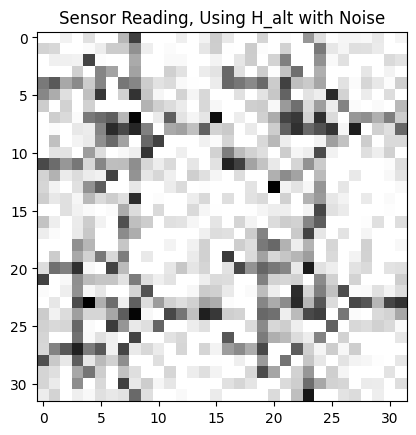

In [23]:
# Sensor readings
sr = np.load(sensorFilename + ".npy")

plt.imshow(np.reshape(sr, (width, height)), cmap="gray", interpolation="nearest")
plt.title("Sensor Reading, Using H_alt with Noise")

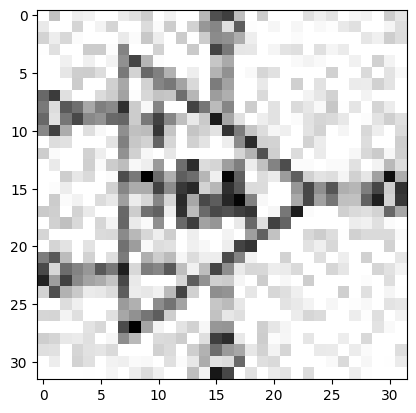

In [24]:
# TODO: Create the image vector from `H_alt` and `sr`
# Hint: You need to perform a matrix operation before multiplying
iv = np.dot(np.linalg.inv(H_alt), sr)

img = np.reshape(iv, (height, width))

plt.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=255)

#### You are done for the week, and are ready to sign up for checkoff. DO NOT delete / close your notebook before being checked off.

<a id='checkoff'></a>
# Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://forms.gle/5W8u2thJzsmWLDsa9)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff Queue](https://lab.eecs16a.org)** It is fine if only one person from your group submits the lab queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join your breakout room when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!

## **<span style="color:red"> Please have your notebook ready to demo before being checked off. </span>**

